<a href="https://colab.research.google.com/github/varun30032002/DeepLearning/blob/main/HomeWork_3_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchvision

In [2]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [3]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [5]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 10])


In [9]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission_df = pd.read_csv("sample_submission.csv")

In [10]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [13]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [14]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

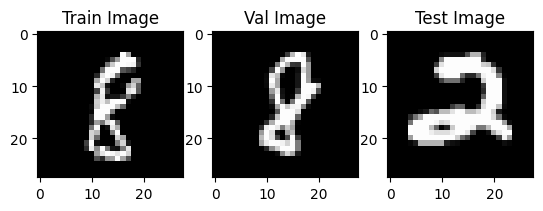

In [15]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [16]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 9/9 [00:16<00:00,  1.80s/it]


------------------------------
Train Loss EPOCH 1: 2.2134
Valid Loss EPOCH 1: 1.9963


  2%|▎         | 1/40 [11:39<7:34:32, 699.30s/it]

Train Accuracy EPOCH 1: 0.1894
Valid Accuracy EPOCH 1: 0.2871
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.88s/it]


------------------------------
Train Loss EPOCH 2: 1.8090
Valid Loss EPOCH 2: 1.6022


  5%|▌         | 2/40 [22:56<7:14:42, 686.37s/it]

Train Accuracy EPOCH 2: 0.3834
Valid Accuracy EPOCH 2: 0.4660
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


------------------------------
Train Loss EPOCH 3: 1.5788
Valid Loss EPOCH 3: 1.4217


  8%|▊         | 3/40 [34:05<6:58:25, 678.52s/it]

Train Accuracy EPOCH 3: 0.4939
Valid Accuracy EPOCH 3: 0.5960
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 4: 1.4037
Valid Loss EPOCH 4: 1.2392


 10%|█         | 4/40 [45:11<6:44:11, 673.64s/it]

Train Accuracy EPOCH 4: 0.5834
Valid Accuracy EPOCH 4: 0.6562
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


------------------------------
Train Loss EPOCH 5: 1.2622
Valid Loss EPOCH 5: 1.1325


 12%|█▎        | 5/40 [56:24<6:32:41, 673.19s/it]

Train Accuracy EPOCH 5: 0.6407
Valid Accuracy EPOCH 5: 0.6986
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.73s/it]


------------------------------
Train Loss EPOCH 6: 1.1619
Valid Loss EPOCH 6: 0.9960


 15%|█▌        | 6/40 [1:07:35<6:21:05, 672.50s/it]

Train Accuracy EPOCH 6: 0.6749
Valid Accuracy EPOCH 6: 0.7379
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


------------------------------
Train Loss EPOCH 7: 1.0866
Valid Loss EPOCH 7: 0.9518


 18%|█▊        | 7/40 [1:18:44<6:09:15, 671.37s/it]

Train Accuracy EPOCH 7: 0.6970
Valid Accuracy EPOCH 7: 0.7550
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 8: 1.0259
Valid Loss EPOCH 8: 0.9028


 20%|██        | 8/40 [1:29:50<5:57:13, 669.79s/it]

Train Accuracy EPOCH 8: 0.7151
Valid Accuracy EPOCH 8: 0.7626
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


------------------------------
Train Loss EPOCH 9: 0.9586
Valid Loss EPOCH 9: 0.8220


 22%|██▎       | 9/40 [1:40:57<5:45:35, 668.90s/it]

Train Accuracy EPOCH 9: 0.7396
Valid Accuracy EPOCH 9: 0.8019
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.86s/it]


------------------------------
Train Loss EPOCH 10: 0.9147
Valid Loss EPOCH 10: 0.7962


 25%|██▌       | 10/40 [1:52:11<5:35:14, 670.47s/it]

Train Accuracy EPOCH 10: 0.7505
Valid Accuracy EPOCH 10: 0.7995
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.78s/it]


------------------------------
Train Loss EPOCH 11: 0.8591
Valid Loss EPOCH 11: 0.7732


 28%|██▊       | 11/40 [2:03:39<5:26:31, 675.58s/it]

Train Accuracy EPOCH 11: 0.7676
Valid Accuracy EPOCH 11: 0.7990
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.80s/it]


------------------------------
Train Loss EPOCH 12: 0.8320
Valid Loss EPOCH 12: 0.7009


 30%|███       | 12/40 [2:15:01<5:16:17, 677.77s/it]

Train Accuracy EPOCH 12: 0.7748
Valid Accuracy EPOCH 12: 0.8274
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 13: 0.7724
Valid Loss EPOCH 13: 0.6448


 32%|███▎      | 13/40 [2:26:12<5:04:00, 675.58s/it]

Train Accuracy EPOCH 13: 0.7945
Valid Accuracy EPOCH 13: 0.8431
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.84s/it]


------------------------------
Train Loss EPOCH 14: 0.7353
Valid Loss EPOCH 14: 0.5960


 35%|███▌      | 14/40 [2:37:24<4:52:17, 674.50s/it]

Train Accuracy EPOCH 14: 0.8062
Valid Accuracy EPOCH 14: 0.8640
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 15: 0.6885
Valid Loss EPOCH 15: 0.5703


 38%|███▊      | 15/40 [2:48:38<4:40:57, 674.31s/it]

Train Accuracy EPOCH 15: 0.8216
Valid Accuracy EPOCH 15: 0.8712
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.83s/it]


------------------------------
Train Loss EPOCH 16: 0.6557
Valid Loss EPOCH 16: 0.5282


 40%|████      | 16/40 [2:59:48<4:29:14, 673.12s/it]

Train Accuracy EPOCH 16: 0.8311
Valid Accuracy EPOCH 16: 0.8805
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 17: 0.6215
Valid Loss EPOCH 17: 0.5148


 42%|████▎     | 17/40 [3:10:57<4:17:29, 671.72s/it]

Train Accuracy EPOCH 17: 0.8389
Valid Accuracy EPOCH 17: 0.8819
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


------------------------------
Train Loss EPOCH 18: 0.5845
Valid Loss EPOCH 18: 0.4816


 45%|████▌     | 18/40 [3:22:08<4:06:13, 671.50s/it]

Train Accuracy EPOCH 18: 0.8491
Valid Accuracy EPOCH 18: 0.8919
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


------------------------------
Train Loss EPOCH 19: 0.5567
Valid Loss EPOCH 19: 0.4476


 48%|████▊     | 19/40 [3:33:19<3:54:59, 671.40s/it]

Train Accuracy EPOCH 19: 0.8563
Valid Accuracy EPOCH 19: 0.9002
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.80s/it]


------------------------------
Train Loss EPOCH 20: 0.5371
Valid Loss EPOCH 20: 0.4422


 50%|█████     | 20/40 [3:44:26<3:43:23, 670.19s/it]

Train Accuracy EPOCH 20: 0.8584
Valid Accuracy EPOCH 20: 0.8974
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


------------------------------
Train Loss EPOCH 21: 0.5074
Valid Loss EPOCH 21: 0.4424


 52%|█████▎    | 21/40 [3:55:32<3:31:49, 668.93s/it]

Train Accuracy EPOCH 21: 0.8682
Valid Accuracy EPOCH 21: 0.8907
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.73s/it]


------------------------------
Train Loss EPOCH 22: 0.4795
Valid Loss EPOCH 22: 0.3974


 55%|█████▌    | 22/40 [4:06:43<3:20:53, 669.63s/it]

Train Accuracy EPOCH 22: 0.8756
Valid Accuracy EPOCH 22: 0.9081
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.79s/it]


------------------------------
Train Loss EPOCH 23: 0.4675
Valid Loss EPOCH 23: 0.3865


 57%|█████▊    | 23/40 [4:17:48<3:09:16, 668.00s/it]

Train Accuracy EPOCH 23: 0.8774
Valid Accuracy EPOCH 23: 0.9062
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.81s/it]


------------------------------
Train Loss EPOCH 24: 0.4501
Valid Loss EPOCH 24: 0.3649


 60%|██████    | 24/40 [4:29:14<2:59:36, 673.54s/it]

Train Accuracy EPOCH 24: 0.8801
Valid Accuracy EPOCH 24: 0.9174
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.78s/it]


------------------------------
Train Loss EPOCH 25: 0.4327
Valid Loss EPOCH 25: 0.3626


 62%|██████▎   | 25/40 [4:40:23<2:48:00, 672.04s/it]

Train Accuracy EPOCH 25: 0.8852
Valid Accuracy EPOCH 25: 0.9152
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


------------------------------
Train Loss EPOCH 26: 0.4091
Valid Loss EPOCH 26: 0.3413


 65%|██████▌   | 26/40 [4:51:34<2:36:44, 671.75s/it]

Train Accuracy EPOCH 26: 0.8907
Valid Accuracy EPOCH 26: 0.9140
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 27: 0.3992
Valid Loss EPOCH 27: 0.3102


 68%|██████▊   | 27/40 [5:02:46<2:25:34, 671.85s/it]

Train Accuracy EPOCH 27: 0.8926
Valid Accuracy EPOCH 27: 0.9264
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 28: 0.3826
Valid Loss EPOCH 28: 0.3105


 70%|███████   | 28/40 [5:13:54<2:14:10, 670.84s/it]

Train Accuracy EPOCH 28: 0.8961
Valid Accuracy EPOCH 28: 0.9260
------------------------------


100%|██████████| 9/9 [00:16<00:00,  1.82s/it]


------------------------------
Train Loss EPOCH 29: 0.3700
Valid Loss EPOCH 29: 0.3032


 72%|███████▎  | 29/40 [5:25:04<2:02:56, 670.63s/it]

Train Accuracy EPOCH 29: 0.8998
Valid Accuracy EPOCH 29: 0.9248
------------------------------


100%|██████████| 9/9 [00:18<00:00,  2.10s/it]


------------------------------
Train Loss EPOCH 30: 0.3713
Valid Loss EPOCH 30: 0.3110


 75%|███████▌  | 30/40 [5:36:25<1:52:15, 673.59s/it]

Train Accuracy EPOCH 30: 0.8984
Valid Accuracy EPOCH 30: 0.9200
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.76s/it]


------------------------------
Train Loss EPOCH 31: 0.3550
Valid Loss EPOCH 31: 0.2834


 78%|███████▊  | 31/40 [5:47:32<1:40:45, 671.73s/it]

Train Accuracy EPOCH 31: 0.9037
Valid Accuracy EPOCH 31: 0.9269
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.76s/it]


------------------------------
Train Loss EPOCH 32: 0.3377
Valid Loss EPOCH 32: 0.2866


 80%|████████  | 32/40 [5:58:46<1:29:37, 672.24s/it]

Train Accuracy EPOCH 32: 0.9072
Valid Accuracy EPOCH 32: 0.9298
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.76s/it]


------------------------------
Train Loss EPOCH 33: 0.3272
Valid Loss EPOCH 33: 0.2652


 82%|████████▎ | 33/40 [6:10:06<1:18:42, 674.57s/it]

Train Accuracy EPOCH 33: 0.9099
Valid Accuracy EPOCH 33: 0.9321
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 34: 0.3219
Valid Loss EPOCH 34: 0.2540


 85%|████████▌ | 34/40 [6:21:19<1:07:25, 674.29s/it]

Train Accuracy EPOCH 34: 0.9107
Valid Accuracy EPOCH 34: 0.9352
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 35: 0.3097
Valid Loss EPOCH 35: 0.2613


 88%|████████▊ | 35/40 [6:32:40<56:21, 676.30s/it]  

Train Accuracy EPOCH 35: 0.9138
Valid Accuracy EPOCH 35: 0.9331
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 36: 0.3040
Valid Loss EPOCH 36: 0.2315


 90%|█████████ | 36/40 [6:43:57<45:05, 676.39s/it]

Train Accuracy EPOCH 36: 0.9156
Valid Accuracy EPOCH 36: 0.9400
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


------------------------------
Train Loss EPOCH 37: 0.2959
Valid Loss EPOCH 37: 0.2455


 92%|█████████▎| 37/40 [6:55:05<33:41, 673.90s/it]

Train Accuracy EPOCH 37: 0.9183
Valid Accuracy EPOCH 37: 0.9338
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.76s/it]


------------------------------
Train Loss EPOCH 38: 0.2898
Valid Loss EPOCH 38: 0.2345


 95%|█████████▌| 38/40 [7:06:15<22:25, 672.74s/it]

Train Accuracy EPOCH 38: 0.9185
Valid Accuracy EPOCH 38: 0.9362
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


------------------------------
Train Loss EPOCH 39: 0.2941
Valid Loss EPOCH 39: 0.2418


 98%|█████████▊| 39/40 [7:17:22<11:11, 671.10s/it]

Train Accuracy EPOCH 39: 0.9167
Valid Accuracy EPOCH 39: 0.9369
------------------------------


100%|██████████| 9/9 [00:15<00:00,  1.73s/it]


------------------------------
Train Loss EPOCH 40: 0.2792
Valid Loss EPOCH 40: 0.2352


100%|██████████| 40/40 [7:28:33<00:00, 672.85s/it]

Train Accuracy EPOCH 40: 0.9213
Valid Accuracy EPOCH 40: 0.9379
------------------------------
Training Time: 26914.00s


In [18]:
torch.cuda.empty_cache()

In [19]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 8/8 [00:14<00:00,  1.87s/it]


<Figure size 640x480 with 0 Axes>

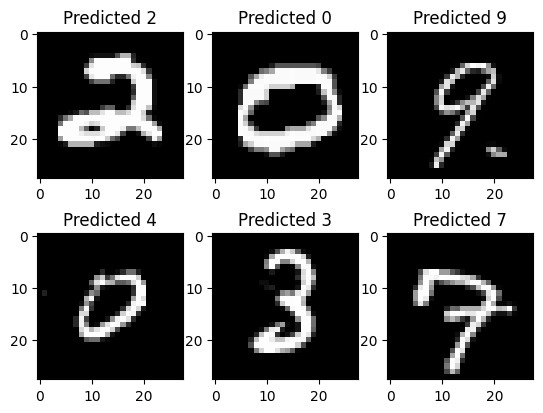

In [20]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1